In [79]:
import os
import re
import pandas as pd
import seaborn as sns
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap
from pyrealm import pmodel
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
### Import the additional site informations 
### SITE_ID, SITE_NAME, LAT, LONG

site_key=pd.read_csv('/Users/abigailbase/PROJECT FILES/site_key.csv')

In [3]:
site_key.head()

,SITE_ID,SITE_NAME,LAT,LONG
0,AR-SLu,San Luis,-33.4648,-66.4598
1,AR-Vir,Virasoro,-28.2395,-56.1886
2,AT-Neu,Neustift,47.1167,11.3175
3,AU-ASM,Alice Springs,-22.2830,133.2490
4,AU-Ade,Adelaide River,-13.0769,131.1178


In [4]:
#Import the 

df=pd.read_csv('/Users/abigailbase/PROJECT FILES/FINAL DF/final_df.csv')

Below is a plot of the sites on a world map

In [5]:
site_key.head()

,SITE_ID,SITE_NAME,LAT,LONG
0,AR-SLu,San Luis,-33.4648,-66.4598
1,AR-Vir,Virasoro,-28.2395,-56.1886
2,AT-Neu,Neustift,47.1167,11.3175
3,AU-ASM,Alice Springs,-22.2830,133.2490
4,AU-Ade,Adelaide River,-13.0769,131.1178


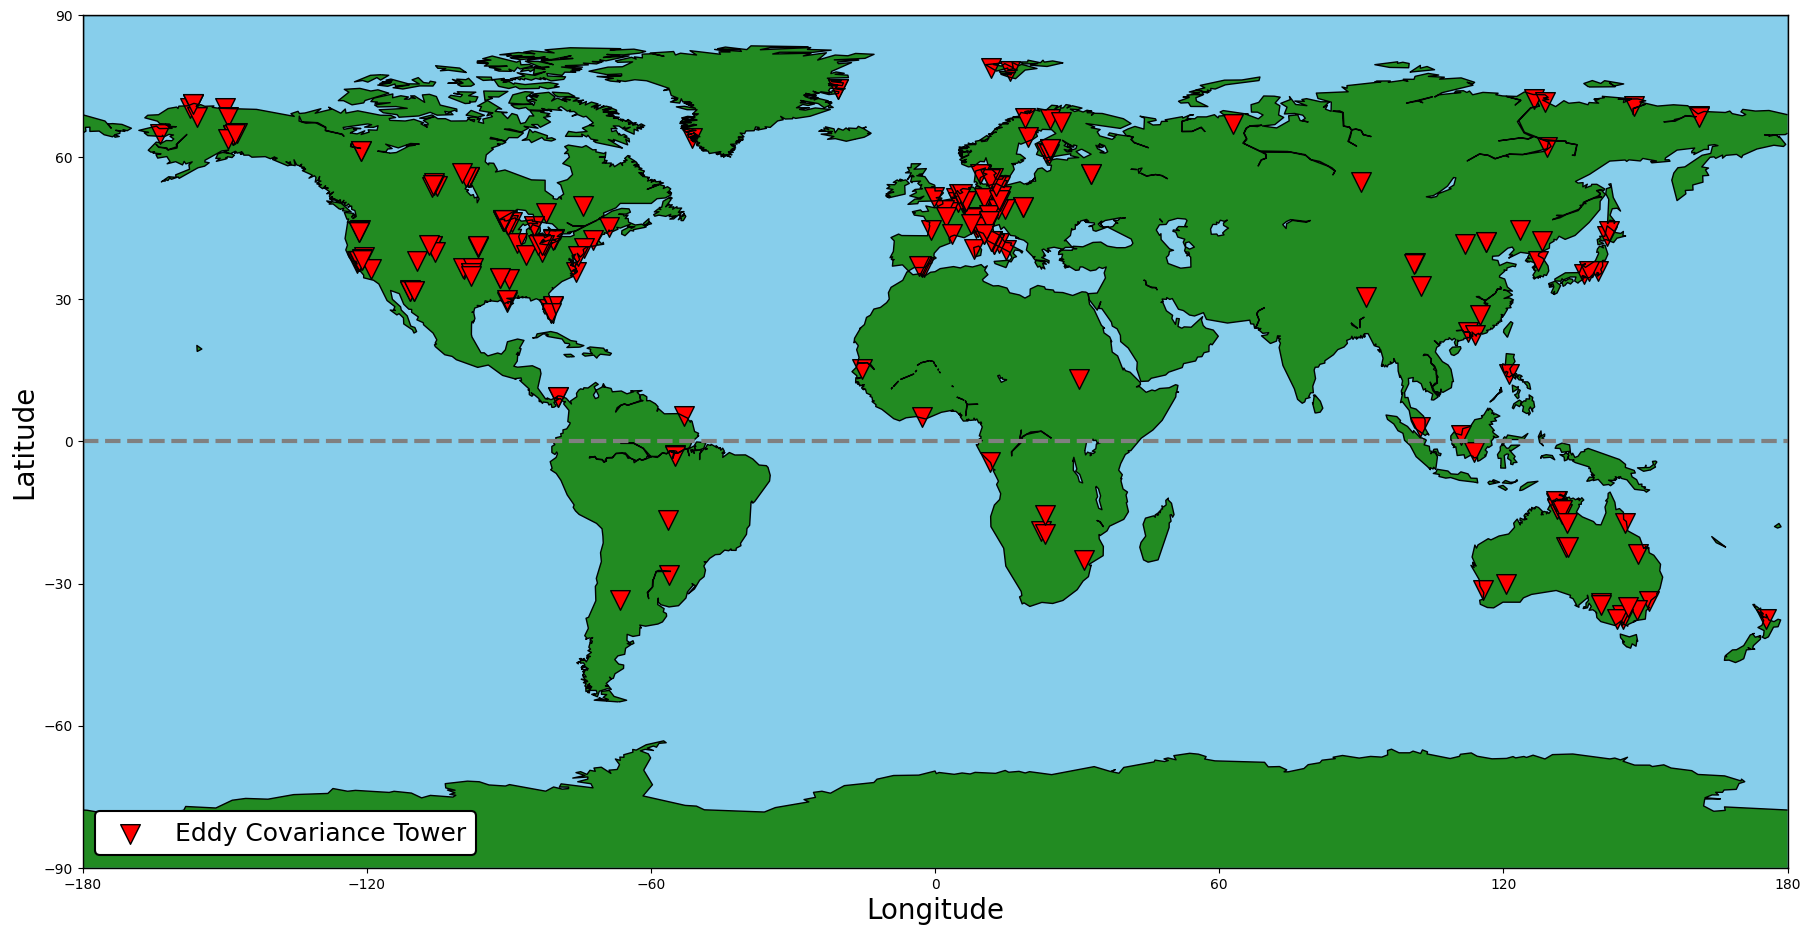

In [6]:
fig, ax = plt.subplots(figsize=(22, 14))

map = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, resolution='c', ax=ax)

map.drawcoastlines()
map.fillcontinents(color='forestgreen', lake_color='skyblue')

map.drawmapboundary(fill_color='skyblue')

### add the sites

map.scatter(site_key['LONG'],site_key['LAT'],marker='v',color='red',edgecolor='black',s=200)

### add the equator

map.plot([-180, 180], [0, 0], color='grey', linewidth=3, linestyle='--', label='Equator')

### add lat lon axis

ax.set_xticks(np.arange(-180, 181, 60))
ax.set_yticks(np.arange(-90, 91, 30))
ax.set_ylabel('Latitude',fontsize=20)
ax.set_xlabel('Longitude',fontsize=20)

dummy_scatter = plt.scatter([], [], color='red', marker='v', s=200,edgecolors='black', label='Eddy Covariance Tower')

legend=plt.legend(handles=[dummy_scatter], loc='lower left', fontsize=18)

frame = legend.get_frame()
frame.set_edgecolor('black')      # Edge color
frame.set_linewidth(1.5)          # Edge linewidth
frame.set_alpha(1)      

plt.show()

---

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836813 entries, 0 to 836812
Data columns (total 79 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             836813 non-null  int64  
 1   TIMESTAMP              836813 non-null  int64  
 2   TA_F                   571541 non-null  float64
 3   SW_IN_F                571541 non-null  float64
 4   LW_IN_F                571541 non-null  float64
 5   VPD_F                  571541 non-null  float64
 6   PA_F                   571541 non-null  float64
 7   P_F                    571541 non-null  float64
 8   WS_F                   571541 non-null  float64
 9   USTAR                  571541 non-null  float64
 10  NETRAD                 549602 non-null  float64
 11  PPFD_IN                506101 non-null  float64
 12  PPFD_OUT               263264 non-null  float64
 13  SW_OUT                 441425 non-null  float64
 14  CO2_F_MDS              571541 non-nu

---

lots of variables are alternative methods of calulating the key variables so will be put aside. 

In [8]:
final_df=df[['TIMESTAMP','TA_F','PA_F','VPD_F','P_F','WS_F',
            'PPFD_IN','PPFD_OUT','CO2_F_MDS','TS_F_MDS_1',
           'SWC_F_MDS_1','NEE_VUT_REF','GPP_DT_VUT_REF']]

In [9]:
final_df.head()

,TIMESTAMP,TA_F,PA_F,VPD_F,P_F,WS_F,PPFD_IN,PPFD_OUT,CO2_F_MDS,TS_F_MDS_1,SWC_F_MDS_1,NEE_VUT_REF,GPP_DT_VUT_REF
0,200101,-15.366,98.150,0.709,0.268,1.872,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.308477,1.01440
1,200102,-21.444,98.641,0.693,0.130,1.710,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.313358,2.01791
2,200103,-9.496,98.429,1.166,0.333,1.835,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.310358,2.86919
3,200104,-0.423,98.305,2.992,0.204,1.902,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.310643,4.16827
4,200105,7.696,97.925,4.874,0.911,2.283,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.308477,4.34089


Now going to extract the month and year 

In [10]:
final_df['TIMESTAMP'].dtype #check data type = int64

dtype('int64')

In [11]:
### need to determine the types of timestamps so that they can be 
# correctly converted

print(final_df['TIMESTAMP'].unique().tolist())



[200101, 200102, 200103, 200104, 200105, 200106, 200107, 200108, 200109, 200110, 200111, 200112, 200201, 200202, 200203, 200204, 200205, 200206, 200207, 200208, 200209, 200210, 200211, 200212, 200301, 200302, 200303, 200304, 200305, 200306, 200307, 200308, 200309, 200310, 200311, 200312, 200401, 200402, 200403, 200404, 200405, 200406, 200407, 200408, 200409, 200410, 200411, 200412, 200501, 200502, 200503, 200504, 200505, 200506, 200507, 200508, 200509, 200510, 200511, 200512, 20010101, 20010102, 20010103, 20010104, 20010105, 20010106, 20010107, 20010108, 20010109, 20010110, 20010111, 20010112, 20010113, 20010114, 20010115, 20010116, 20010117, 20010118, 20010119, 20010120, 20010121, 20010122, 20010123, 20010124, 20010125, 20010126, 20010127, 20010128, 20010129, 20010130, 20010131, 20010201, 20010202, 20010203, 20010204, 20010205, 20010206, 20010207, 20010208, 20010209, 20010210, 20010211, 20010212, 20010213, 20010214, 20010215, 20010216, 20010217, 20010218, 20010219, 20010220, 20010221,

In [ ]:
### seperate the data into 2 dfs for the differing datatime format 

In [12]:
def identify_format(date_str):
    if len(date_str) == 8:  #YYYY%MM%DD 
        return 'full_date'
    elif len(date_str) == 6:  #YYYY%MM 
        return 'month_year'
    else:
        return 'invalid'

In [36]:
date_df=final_df.copy()

In [37]:
date_df['TIMESTAMP'] = date_df['TIMESTAMP'].astype(str)

In [38]:
date_df['TIMESTAMP'].dtype

dtype('O')

In [39]:
#create dummy column to flag the date type

date_df['date_type']=date_df['TIMESTAMP'].apply(identify_format)

In [40]:
full_date=date_df[date_df['date_type']=='full_date'] #YYYY%MM%DD

In [41]:
month_year=date_df[date_df['date_type']=='month_year']

In [42]:
full_date.head()

,TIMESTAMP,TA_F,PA_F,VPD_F,P_F,WS_F,PPFD_IN,PPFD_OUT,CO2_F_MDS,TS_F_MDS_1,SWC_F_MDS_1,NEE_VUT_REF,GPP_DT_VUT_REF,date_type
60,20010101,-12.541,98.042,0.719,0.336,2.339,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.321625,full_date
61,20010102,-18.309,98.586,0.611,0.099,0.816,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.721820,full_date
62,20010103,-13.912,98.081,0.630,0.158,1.418,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.301790,1.202700,full_date
63,20010104,-10.072,96.457,0.936,1.441,3.089,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.421478,full_date
64,20010105,-20.642,97.479,0.631,0.392,1.446,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.540661,full_date


In [43]:
full_date=full_date.drop(columns='date_type')

In [44]:
full_date["TIMESTAMP"].dtype

dtype('O')

In [45]:
full_date['TIMESTAMP']=full_date['TIMESTAMP'].astype(int)

In [46]:
full_date.head()

,TIMESTAMP,TA_F,PA_F,VPD_F,P_F,WS_F,PPFD_IN,PPFD_OUT,CO2_F_MDS,TS_F_MDS_1,SWC_F_MDS_1,NEE_VUT_REF,GPP_DT_VUT_REF
60,20010101,-12.541,98.042,0.719,0.336,2.339,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.321625
61,20010102,-18.309,98.586,0.611,0.099,0.816,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.721820
62,20010103,-13.912,98.081,0.630,0.158,1.418,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.301790,1.202700
63,20010104,-10.072,96.457,0.936,1.441,3.089,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.421478
64,20010105,-20.642,97.479,0.631,0.392,1.446,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.540661


In [33]:
full_date['TIMESTAMP'].dtype

dtype('O')

In [34]:
full_date.head()

,TIMESTAMP,TA_F,PA_F,VPD_F,P_F,WS_F,PPFD_IN,PPFD_OUT,CO2_F_MDS,TS_F_MDS_1,SWC_F_MDS_1,NEE_VUT_REF,GPP_DT_VUT_REF
60,2001-01-01,-12.541,98.042,0.719,0.336,2.339,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.321625
61,2001-01-02,-18.309,98.586,0.611,0.099,0.816,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.721820
62,2001-01-03,-13.912,98.081,0.630,0.158,1.418,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.301790,1.202700
63,2001-01-04,-10.072,96.457,0.936,1.441,3.089,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.421478
64,2001-01-05,-20.642,97.479,0.631,0.392,1.446,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.540661


In [48]:
full_date['TIMESTAMP'] = pd.to_datetime(full_date['TIMESTAMP'], format='%Y%m%d')


In [49]:
full_date['TIMESTAMP'].dtype

dtype('<M8[ns]')

In [50]:
### extract the year, month and day for full_date

full_date.loc[:, 'YEAR'] = full_date['TIMESTAMP'].dt.year


In [51]:
full_date.loc[:, 'MONTH'] = full_date['TIMESTAMP'].dt.month

In [52]:
full_date.loc[:, 'DAY'] = full_date['TIMESTAMP'].dt.day

In [53]:
full_date=full_date.drop(columns='TIMESTAMP')

In [54]:
print(month_year.shape)
print(full_date.shape)

(19068, 14)
(580386, 15)


In [ ]:
### Going to drop the month_year as i dont think itll have 
### much use there is only 19,068 data points

***Data cleaning***

1. Investigate the missingness

In [55]:
full_date.head()

,TA_F,PA_F,VPD_F,P_F,WS_F,PPFD_IN,PPFD_OUT,CO2_F_MDS,TS_F_MDS_1,SWC_F_MDS_1,NEE_VUT_REF,GPP_DT_VUT_REF,YEAR,MONTH,DAY
60,-12.541,98.042,0.719,0.336,2.339,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.321625,2001,1,1
61,-18.309,98.586,0.611,0.099,0.816,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.721820,2001,1,2
62,-13.912,98.081,0.630,0.158,1.418,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.301790,1.202700,2001,1,3
63,-10.072,96.457,0.936,1.441,3.089,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.243493,0.421478,2001,1,4
64,-20.642,97.479,0.631,0.392,1.446,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.386648,0.540661,2001,1,5


In [56]:
full_date.isna().sum() #No missing values in each column

TA_F               28488
PA_F               28488
VPD_F              28488
P_F                28488
WS_F               28488
PPFD_IN            91679
PPFD_OUT          326170
CO2_F_MDS          28488
TS_F_MDS_1         50403
SWC_F_MDS_1       121991
NEE_VUT_REF        28488
GPP_DT_VUT_REF     28488
YEAR                   0
MONTH                  0
DAY                    0
dtype: int64

In [59]:
print(full_date.shape)

(580386, 15)


2. plot the observations per month and year to investigate

In [60]:
monthly_count=full_date.groupby(['MONTH']).size().reset_index(name='counts')

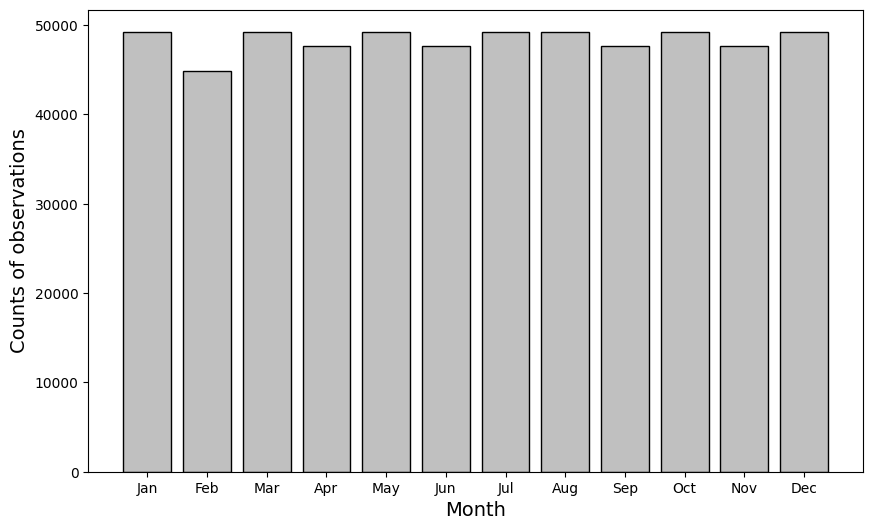

In [95]:
month_abbr = {i: calendar.month_abbr[i] for i in range(1, 13)}

# Create a bar plot with custom colors and edge colors, and custom x-tick labels
plt.figure(figsize=(10, 6))
plt.bar(monthly_count['MONTH'], monthly_count['counts'], color='silver', edgecolor='black')
plt.xlabel('Month',fontsize=14)
plt.ylabel('Counts of observations',fontsize=14)
plt.xticks(monthly_count['MONTH'], [month_abbr[month] for month in monthly_count['MONTH']])
plt.show()

2. rename variables 

In [ ]:
var_names={'GPP_DT_VUT_REF':'GPP','TA_F':'temp','PA_F':'pres','VPD':'VPD','CO2_F_MDS':'CO2_MF','PPFD_IN':'PPFD','Site_Name':'SITE_ID'}

In [ ]:
with_time=with_time.rename(columns=var_names)

In [ ]:
with_time['month'].unique()

In [ ]:
with_time.head()

3. New variable for investingating seasonal changes

In [ ]:
mon_avg_temp=with_time.groupby('month')['temp'].mean()


Now i will add a new column for northern and southern hemisphere to investigate the seasonal changes as they have opposite seasons.

In [ ]:
with_time['year'].unique() #the data only goes to 2014

- going to be doing a left join to bring over the lat and lon data from the site_key df for hemisphere assignment

In [ ]:
site_key_merge=site_key.drop(columns='SITE_NAME')

In [ ]:
final_df=pd.merge(with_time,site_key_merge,on='SITE_ID')

In [ ]:
final_df.head()

Now need to filter so that SH= Lat<0 and NH=Lat>=0

In [ ]:
final_df['hemisphere']=final_df['LAT'].apply(lambda x: 'NH' if x>=0 else 'SH')

In [ ]:
final_df.head()

Check for missing time periods in each hemisphere

In [ ]:
monthly_count=final_df.groupby(['hemisphere','month',]).size().reset_index(name='counts')

In [ ]:
NH_count=monthly_count[monthly_count['hemisphere']=='NH']
SH_count=monthly_count[monthly_count['hemisphere']=='SH']

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))


ax1.set_xlabel('Month',fontsize=14)
ax1.set_ylabel('Observations in Northern Hemisphere',fontsize=14)
NH_line=ax1.plot(NH_count['month'], NH_count['counts'], color='blue', marker='o', label='Northern Hemisphere')
ax1.tick_params(axis='y')
ax1.tick_params(axis='y', labelsize=12) 
ax1.tick_params(axis='x', labelsize=12)

ax2 = ax1.twinx()
ax2.set_ylabel('Observations in Southern Hemisphere',fontsize=14)
SH_line=ax2.plot(SH_count['month'], SH_count['counts'], color='red', marker='s', label='Southern Hemisphere')
ax2.tick_params(axis='y')
ax2.tick_params(axis='y', labelsize=12)  

lines = NH_line + SH_line
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left',fontsize=14)


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Create two subplots side by side

# Plot for Northern Hemisphere
ax1.plot(NH_count['month'], NH_count['counts'], color='blue', marker='o', label='Northern Hemisphere')
ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Observations in Northern Hemisphere', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.legend(loc='upper left', fontsize=14)
ax1.set_title('Northern Hemisphere Observations', fontsize=16)

# Plot for Southern Hemisphere
ax2.plot(SH_count['month'], SH_count['counts'], color='red', marker='s', label='Southern Hemisphere')
ax2.set_xlabel('Month', fontsize=14)
ax2.set_ylabel('Observations in Southern Hemisphere', fontsize=14)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(loc='upper left', fontsize=14)
ax2.set_title('Southern Hemisphere Observations', fontsize=16)

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

each show the same pattern implying the missingnuss isnt at random (MNAR). with particularly low in feb. Why? 

In [ ]:
final_df[final_df['hemisphere']=='SH'].head()

In [ ]:
final_df[final_df['year']==2001].head(50)

***Run p-model***

In [ ]:
env  = pmodel.PModelEnvironment(tc=final_df['temp'].values, patm=final_df['pres'].values * 1000, vpd=final_df['VPD_F'].values * 100, co2=final_df['CO2_MF'].values)
model = pmodel.PModel(env, method_optchi='prentice14')
model.estimate_productivity(fapar=df['NIRv'].values * 0.3, ppfd=final_df['PPFD'].values)

df['GPP_P-model'] = model.gpp
df[['GPP_DT_VUT_REF', 'GPP_P-model']].plot()

Yearly counts

In [ ]:
yearly_count=final_df.groupby(['hemisphere','year',]).size().reset_index(name='counts')

In [ ]:
NH_year=yearly_count[yearly_count['hemisphere']=='NH']
SH_year=yearly_count[yearly_count['hemisphere']=='SH']

In [ ]:
fig, ax3 = plt.subplots(figsize=(12, 6))


ax3.set_xlabel('Year',fontsize=14)
ax3.set_ylabel('Observations in Northern Hemisphere',fontsize=14)
NH_line2=ax3.plot(NH_year['year'], NH_year['counts'], color='blue', marker='o', label='Northern Hemisphere')
ax3.tick_params(axis='y')
ax3.tick_params(axis='y', labelsize=12) 
ax3.tick_params(axis='x', labelsize=12)

ax4 = ax3.twinx()
ax4.set_ylabel('Observations in Southern Hemisphere',fontsize=14)
SH_line2=ax4.plot(SH_year['year'], SH_year['year'], color='red', marker='s', label='Southern Hemisphere')
ax4.tick_params(axis='y')
ax4.tick_params(axis='y', labelsize=12)  

lines2 = NH_line2 + SH_line2
labels2 = [line.get_label() for line in lines2]
ax1.legend(lines2, labels2, loc='upper left',fontsize=14)

In [ ]:
yearsSH=final_df[final_df['hemisphere']=='SH']

In [ ]:
yearsSH['year'].unique()

* there is not sufficient timestamped data from 

4. outlier detection

In [ ]:
bp_data=final_df.drop(columns=['year','month','GPP','LAT','LONG','hemisphere','SITE_ID']) 

In [ ]:
bp_data.head()

In [ ]:
for column in bp_data.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=bp_data[column])  # Use y=bp_data[column] for vertical boxplots
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3,ncols=3)

In [ ]:
pp_labels={'temp':'Temperature (°C)','pres':'Pressure (kPa)','VPD_F':"VPD (hPa)",'CO2_MF':"CO\u2082 MF (µmolCO\u2082mol\u00B9)",'PPFD':"PPFD (µmolPhotonm\u00B2s\u207B\u00B9)"}

In [ ]:
sns.set_palette("bright")

In [ ]:
pp=sns.pairplot(bp_data,diag_kind='kde')

for ax in pp.axes.flatten():
    ax.set_xlabel(pp_labels.get(ax.get_xlabel(), ax.get_xlabel()))
    ax.set_ylabel(pp_labels.get(ax.get_ylabel(), ax.get_ylabel()))
 


Feature importance test

In [ ]:
df=pd.read_csv('/Users/abigailbase/Desktop/RESEARCH PROJECT/DATA/BE-Bra_pmodel.csv',index_col=0)

In [ ]:
env  = pmodel.PModelEnvironment(tc=df['TA_F'].values, patm=df['PA_F'].values * 1000, vpd=df['VPD_F'].values * 100, co2=df['CO2_F_MDS'].values)
model = pmodel.PModel(env, method_optchi='prentice14')
model.estimate_productivity(fapar=df['NIRv'].values * 0.3, ppfd=df['PPFD_IN'].values)

df['GPP_P-model'] = model.gpp
df[['GPP_DT_VUT_REF', 'GPP_P-model']].plot()

In [ ]:
df.head()

In [ ]:
X = df[['TA_F', 'PA_F', 'VPD_F', 'CO2_F_MDS', 'NIRv', 'PPFD_IN']]
y = df['GPP_P-model']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]


In [ ]:
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({importances[indices[f]]})")


In [ ]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()